2022-03-24 Ludovico Massaccesi

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
from math import floor, ceil

# Bootstrapping
Define a boostrap PRNG, taking the samples from the distribution as input.

In [2]:
def bootstrap(samples, size):
    samples = np.array(samples, copy=False)
    return samples[np.random.randint(0, len(samples), size=size)]

Then, define a test function that draws some samples from a given distribution, and computes the variance of a given estimator using the bootstrap method.

In [3]:
def test_bootstrap(
    distribution, estimator, n_bootstrap, n_estimator, repetitions=100):
    if isinstance(n_bootstrap, int):
        # Draw, from distribution, the samples to feed
        # to the boostrapper
        bootstrap_samples = distribution(size=n_bootstrap)
    else:
        # Take the bootstrap samples from the parameter
        bootstrap_samples = n_bootstrap
    # Estimate the variance of the estimator
    results = []
    for i in range(repetitions):
        samples = bootstrap(bootstrap_samples, size=n_estimator)
        results.append(estimator(samples))
    return np.var(results, ddof=1)

Then, also define a test function that uses the double-bootstrap method to extract the variance of an estimator with an associated uncertainty.

In [4]:
def test_double_bootstrap(
    distribution, estimator, n_bootstrap, n_estimator,
    repetitions_bootstrap=100, repetitions_estimator=100):
    if isinstance(n_bootstrap, int):
        # Draw, from distribution, the samples to feed
        # to the boostrapper
        bootstrap_samples = distribution(size=n_bootstrap)
    else:
        # Take the bootstrap samples from the parameter
        bootstrap_samples = n_bootstrap
        n_bootstrap = len(bootstrap_samples)
    # Estimate the variance multiple times
    variances = []
    for i in range(repetitions_bootstrap):
        # Draw, with the boostrap, the samples to feed to
        # the (second) bootstrapper
        double_bootstrap_samples = bootstrap(
            bootstrap_samples, size=n_bootstrap)
        # Estimate the variance of the estimator
        results = []
        for j in range(repetitions_estimator):
            samples = bootstrap(
                double_bootstrap_samples, size=n_estimator)
            results.append(estimator(samples))
        variances.append(np.var(results, ddof=1))
    return np.mean(variances), np.std(variances, ddof=1)

Define some convenience plotting function, so that we can repeat the test for different distributions/estimators.

In [15]:
def set_fake_log_axis(axis, low, up):
    axis.set_major_formatter(
        mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    yticks = [np.log10(x) for p in range(floor(low),ceil(up))
              for x in np.linspace(10**p, 10**(p+1), 10)]
    axis.set_ticks([x for x in yticks if low <= x <= up], minor=True)
    axis.set_major_locator(mticker.MultipleLocator(1))


def test_and_plot(
    distribution, estimator, n_bootstrap_list, n_estimator_list, title):
    #vw = np.log10(n_estimator_list[1]) - 
    # Make a plot of the variance vs n_estimator, with a
    # different legend entry for each n_bootstrap
    y_min = 10
    for i, nb in enumerate(n_bootstrap_list):
        bs_samples = distribution(size=nb)
        # Compute the single-bootstrap variances for the violin plot
        variances = np.array([[
            test_bootstrap(distribution, estimator, bs_samples, ne)
            for _ in range(100)] for ne in n_estimator_list]).T
        # Compute the double-bootstrap variance with their std
        v2, dv2 = np.array([
            test_double_bootstrap(distribution, estimator, bs_samples, ne)
            for ne in n_estimator_list]).T
        # Plot
        nbs = f"{nb:.1g}".replace("e+0", "\cdot10^")
        nel = np.array(n_estimator_list)
        err_low = np.log10(v2)-np.log10(np.maximum(1e-10,v2-dv2))
        err_hi = np.log10(v2+dv2)-np.log10(v2)
        plt.errorbar(
            np.log10(nel), np.log10(v2),
            np.vstack((err_low, err_hi)),
            fmt='.', c=f"C{i}", label=f"$N_{{bs}} = {nbs}$")
        y_min = min(y_min, err_low.min(where=err_low>-10, initial=y_min))
        plt.violinplot(np.log10(variances), np.log10(n_estimator_list),
                       widths=0.5, showextrema=False)#, c=f"C{i}")
        y_min = min(y_min, np.log10(variances).min())
    plt.title(title)
    plt.grid()
    plt.legend()
    _, y_max = plt.ylim()
    plt.ylim(y_min, y_max)
    set_fake_log_axis(plt.gca().xaxis, *plt.xlim())
    set_fake_log_axis(plt.gca().yaxis, *plt.ylim())
    plt.xlabel("Number of samples fed to the estimator $N_e$")
    plt.ylabel("Variance")

## Results

### Mean on a Gaussian
First look at a mean used on a Gaussian distribution.
The error bars are the results (mean and standard deviation of the variance of the estimator) from the double-bootstrap method, while the violin plots show the distribution of the variances obtained with the single-bootstrap method (using the same samples as a starting point, but bootstrapping a different set of samples each time).

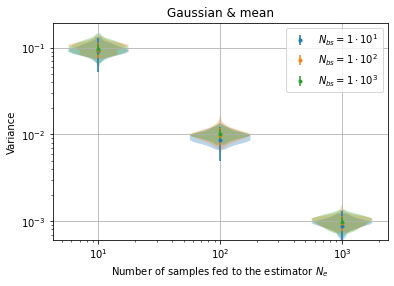

In [19]:
test_and_plot(np.random.standard_normal, np.mean,
              [10, 100, 1000], [10, 100, 1000], "Gaussian & mean")

The variance decreases with the number of samples given to the estimator $N_e$ like $1/N_e$, as expected.

The estimator variance distribution does not seem to depend much on the number of samples used for bootstrapping $N_{bs}$: this might be due to the non-heavy tails of the Gaussian distribution.

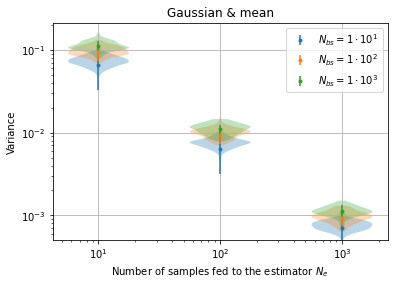

In [24]:
test_and_plot(np.random.standard_normal, np.mean,
              [10, 100, 1000], [10, 100, 1000], "Gaussian & mean")

### Median on a Gaussian

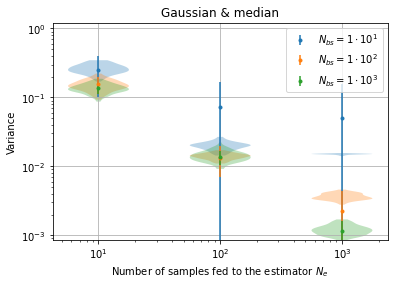

In [18]:
test_and_plot(np.random.standard_normal, np.median,
              [10, 100, 1000], [10, 100, 1000], "Gaussian & median")

Also for the median of a Gaussian the $1/N_e$ pattern is observed as expected.

In this case, the dependence of the variance distribution on $N_{bs}$ is closer to the intuitively-expected behaviour: the variance tends to increase with small $N_{bs}$, and the variance distribution becomes particularly large when using a small number of samples to bootstrap a much larger number of samples.
The fact that this does not happen for the mean might be due to the fact the the arithmetic mean is a uniformly minimum-variance unbiased estimator for the mean of a Gaussian distribution.

### Mean on a Cauchy

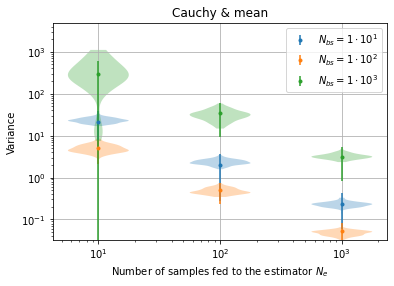

In [22]:
test_and_plot(np.random.standard_cauchy, np.mean,
              [10, 100, 1000], [10, 100, 1000], "Cauchy & mean")

As expected, the mean has a very large variance for Cauchy distributions with respect to Gaussian distributions; still, it seems to decreases like $1/N_e$.

There is no simple formula for the dependence on $N_{bs}$: this is most likely due to the fact that, by increasing the number of initial samples, one also increases the probability of having samples in the heavy tails of the Cauchy, far from the center of the distribution.

### Median on a Cauchy

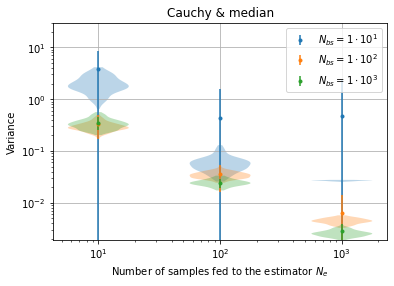

In [23]:
test_and_plot(np.random.standard_cauchy, np.median,
              [10, 100, 1000], [10, 100, 1000], "Cauchy & median")

The median's $1/N_e$ dependence can be observed as expected.

The dependence of the variance distribution on $N_{bs}$ is closer to the expectation: the average variance is lower at higher $N_{bs}$, and using a small $N_{bs}$ to generate a large $N_e$ is unstable.